<a href="https://colab.research.google.com/github/jmlDC/MediaBias-Thesis22-23/blob/Developing-Tool/Scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MEDIA BIAS Thesis

# Setting up Environment

## PIP install

In [1]:
!pip3 install requests-html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 2.6 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1270 sha256=ce1d5cb88b6ba0177db1875ba409e162116782b1aeef219a8ac009d85789cc3a
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24589 sha256=1c8bd0ff7bd25fb8ec8f2234cc265eae35250d286f2b99413ac5e0157d268b36
  Stored in directory: /root/.cache/pip/wheels/70/4b/f0/eaf5a8de646d8676dc25caa01949b9f9d883b8fa2efb435bc3
Successfully built bs4 parse


## Imports

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium

# Install xvfb
apt install -y xvfb

# Install Selenium-Profiles
pip uninstall -y selenium_profiles
pip install --no-cache-dir selenium_profiles>=2.2.6

# pip install https://github.com/kaliiiiiiiiii/Selenium-Profiles/archive/refs/heads/dev.zip # dev-branch

# install python packages
pip install google-colab-shell
pip install webdriver-manager
pip install Pyvirtualdisplay 

Executing: /tmp/apt-key-gpghome.haXPxLc4pF/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.pNgEKXeSJK/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.CCkjC0cvd1/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 https://cloud.r-project.org/bin/l

In [136]:
import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import date
from requests_html import HTMLSession 
import re

## Mounting to GDrive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### dir variable

In [6]:
dir  = "/content/gdrive/MyDrive/THESIS-MS/Git-Thesis22-23/"

# Preperation Scrape

1. GMA7 - infinite scroll but with dates
2. ABS CBN (Online) - has mix of Filipino news **
3. CNN Philippines - limited newslink  **
4. Philippine Star - 
headline/nation infinite scroll
5. Rappler
6. Manila Bulletin - infinite more button
7. TV5
8. Manila Standard
9. Sunstar Philippines

## Extract Source Function

In [7]:
def extract_source(url):
    agent = {"User-Agent":"Chrome/105.0.0.0"}
    try:
      source=requests.get(url, headers=agent)
    except Exception as e:                                   # this describes what to do if an exception is thrown
      error_type, error_obj, error_info = sys.exc_info()      # get the exception information
      print ('ERROR FOR LINK:',url)                          #print the link that cause the problem
      print (error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception
    
    return source                                               #ignore this page. Abandon this and go back.

## Chrome driver

In [17]:
# https://colab.research.google.com/github/kaliiiiiiiiii/Selenium-Profiles/blob/master/google-colab/selenium_profiles.ipynb#scrollTo=lThF-0LvpZf3
## @title Start actual driver
from selenium_profiles.webdriver import Chrome
from selenium_profiles.profiles import profiles
from selenium.webdriver.common.by import By  # locate elements
from selenium_profiles.utils.colab_utils import display, showscreen, show_html # virtual display
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, ElementNotVisibleException, ElementNotSelectableException
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

display = display()

def startChromeDriver():
  options = Options()
  # options.add_argument('--disable-blink-features=AutomationControlled')
  chromedriver_path = ChromeDriverManager(version="90.0.4430.24").install()
  profile = profiles.Windows() # or .Android
  profile["cdp"]["cores"] = None # Chrome 90 doesn't allow emulating cores :(driver = mydriver.start(profile, uc_driver=False, executable_path=chromedriver_path)
  mydriver = Chrome(profile, executable_path=chromedriver_path, options=options)
  display.start_display()
  return mydriver.start()
   

# Media Outlet

## Manila Bulletin

https://www.scrapingbee.com/webscraping-questions/selenium/how-to-scroll-to-element-selenium/#:~:text=You%20can%20scroll%20to%20an,the%20execute_script%20as%20an%20argument.

In [ ]:
## Manila bulletin
# News link getter for National News
# Simulate clicking the more button in MB site, and then extract all the news link

site = "manilaBulletin"
data=pd.DataFrame(columns=['Statement','Link','Date'])
url = 'https://mb.com.ph/category/national'
print(url)

driver = startChromeDriver()
driver.get(url)
driver.implicitly_wait(10)
moreClicks = 0
for x in range(moreClicks):
  try:
    js_code = "arguments[0].scrollIntoView();"
    # The WebElement you want to scroll to
    # element = driver.find_element(By.XPATH, '//*[@id="app"]/div/main/div/div/div/div[3]/div[2]/div[2]/div/div[2]/button')
    element = WebDriverWait(driver, timeout=5).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="app"]/div/main/div/div/div/div[3]/div[2]/div[2]/div/div[2]/button')))
    # Execute the JS script
    driver.execute_script(js_code, element)
    element.click()
    print(x,'clicked')
    # showscreen(driver)
    # time.sleep(2)  
  except Exception as e:                                   
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)                          
      print (error_type, 'Line:', error_info.tb_lineno)  

source = driver.page_source

soup = BeautifulSoup(source, 'html.parser')
links=soup.find("div", {'class' : 'article-list mx-auto'}).find_all('div',attrs={'class':'row mb-5'})
print(len(links))

filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"    

for j in links:
    Statement = j.find('h4', {'class' : 'mb-font-article-title mt-0 mb-1'}).find('a').text.strip()
    Link = "https://mb.com.ph"+j.find("h4", {'class' : 'mb-font-article-title mt-0 mb-1'}).find('a')['href'].strip()
    Date = j.find('div', {'class': 'ml-2'}).text.strip()
    df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
    data = data.append(pd.Series(df_new_row, index=data.columns[:len(df_new_row)]), ignore_index=True)

driver.quit()
# display.stop_display()
data.to_csv(filename)
data.head()

In [ ]:
# Article Reader from LINK
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir}{site}_{date.today()}_NEWS.csv"

for index, row in data.iterrows():
  url = row["Link"] 
  print(url)
  time.sleep(1)   
  soup=BeautifulSoup(extract_source(url).text, 'html.parser')
  text=soup.find("div", {'class' : 'col-md-8 col-xl-8 col-12'})  
  row=[]
  try:
    Title = text.find('h1',{'class':'pt-3 mb-font-article-title'}).text.strip()
    Author = text.find('div',attrs={'class':'mb-font-author-name overflow-nowrap'}).find('a').text.strip()
    Date = text.find('div', attrs={'class': 'pt-0'}).text[:-8]
  except Exception as e:
      pass
  body = ""
  textList =  soup.find('div', {'class':'pt-8 custom-article-body mb-font-article-body'}).find_all('p')
  for t in textList:
    body += (t.text.replace('\u200b', '')) +"\n" 
  row.extend((Title, Author, Date, body))
  data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  print(index)
data2.to_csv(filename)
data2.head()

## ABS CBN *

In [ ]:
## ABS CBN
# pagesToGet= 2
# topic = "Queen Elizabeth Death"
site = "ABS-CBN_NEWS"


data=pd.DataFrame(columns=['Title','Link','Date'])

for page in range(1,pagesToGet+1):
  url = 'https://news.abs-cbn.com/special-pages/search?q='+topic.replace(" ", "%20")+'&gsc.sort=&gsc.page='+str(page)+'#gsc.tab=0&gsc.q='+topic.replace(" ", "%20")+'&gsc.sort=&gsc.page='+str(page)
  print(url)

  driver.get(url)
  # WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.ID, '___gcse_0'))) 
  source = driver.page_source

  time.sleep(2)   
  soup = BeautifulSoup(source, 'html.parser')
  searches = soup.find_all('div', {'class':'gsc-webResult gsc-result'})
  filename= f"{dir}{site}-{topic}-NEWS-List.csv"     

  for x in searches:
    frame=[]
    Title = x.find('div', class_="gs-title").find("a").text.strip()
    Date = x.find('div', class_="gs-bidi-start-align gs-snippet").text[:12].strip()
    Link = x.find('a', class_="gs-title")['href']
    frame.extend((Title, Link, Date, topic))

    data = data.append(pd.Series(frame, index=data.columns[:len(frame)]), ignore_index=True)



data.to_csv(filename)
driver.quit()
data





In [ ]:
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site+'-'+topic}NEWS.csv"

for index, row in data.iterrows():
  url = row["Link"] 
  if ('multimedia/photo' in url):
    pass
  else:
    print(url)

    time.sleep(1)   
    soup=BeautifulSoup(extract_source(url).text, 'html.parser')
      
    row=[]
    
    Title = soup.find('h1',{'class':'news-title'}).text.strip()
    Author = soup.find('span',attrs={'class':'editor'}).text.strip()
    Date = soup.find('span', attrs={'class': 'date-posted'}).text[:-8].strip() 
    
    textList =soup.find("div", {'class' :'article-content'}).find_all("p")
    body = ""
    for t in textList:
      if (t.text != "RELATED VIDEO:"):
        body += (t.text) +"\n" 

    row.extend((Title, Author, Date, body))
    

    data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  
data2.to_csv(filename)
data2.head()

## GMA 

In [28]:
# https://www.gmanetwork.com/news/archives/news-nation
#  https://stackoverflow.com/questions/20986631/how-can-i-scroll-a-web-page-using-selenium-webdriver-in-python
site = "GMA"
data=pd.DataFrame(columns=['Statement','Link','Date'])
url = 'https://www.gmanetwork.com/news/archives/news-nation/'
print(url)

driver = startChromeDriver()
driver.get(url)
driver.implicitly_wait(10)

try:
  SCROLL_PAUSE_TIME = 0.5
  cnt = 2
  # Get scroll height
  last_height = driver.execute_script("return document.body.scrollHeight")
  while cnt>0:
      # Scroll down to bottom
      driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
      # Wait to load page
      time.sleep(SCROLL_PAUSE_TIME)
      # Calculate new scroll height and compare with last scroll height
      new_height = driver.execute_script("return document.body.scrollHeight")
      if new_height == last_height:
          break
      last_height = new_height
      cnt -= 1
      time.sleep(1)
except Exception as e:                                   
  error_type, error_obj, error_info = sys.exc_info()      
  print ('ERROR FOR LINK:',url)                          
  print (error_type, 'Line:', error_info.tb_lineno)  

time.sleep(10)
source = driver.page_source
soup = BeautifulSoup(source, 'html.parser')

linksL=soup.find("ul", {'id' : 'grid_thumbnail_stories'}).find_all('li', {'class':'story left-grid'})
linksR=soup.find("ul", {'id' : 'grid_thumbnail_stories'}).find_all('li', {'class':'story right-grid'})
links = linksL + linksR
print(len(links))

filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"    

for j in links:
    Statement = j.find('div').find('div', {'class': 'story'}).find('div', {'class': 'story_title_holder'}).find('div', {'class' : 'story_title'}).text[:-21].strip()
    Link = j.find('a')['href'].strip()
    Date = j.find('div', {'class' : 'story_title_holder'}).find('div', {'class' : 'story_title'}).find('div', {'class': 'archive_date_time'}).text[:-8].strip()
    df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
    print(Statement, Link, Date)
    data = data.append(pd.Series(df_new_row, index=data.columns[:len(df_new_row)]), ignore_index=True)

driver.quit()
data.to_csv(filename)
data.head()

https://www.gmanetwork.com/news/archives/news-nation/
66
American wanted for fraud, racketeering nabbed — BI https://www.gmanetwork.com/news/topstories/nation/868981/american-wanted-for-fraud-racketeering-nabbed-bi/story/ May 04, 2023
DOH: 12 to 23 years to address shortage of nurses, doctors under existing policies https://www.gmanetwork.com/news/topstories/nation/868972/doh-12-to-23-years-to-address-shortage-of-nurses-doctors-under-existing-policies/story/ May 04, 2023
Over 61M PhilIDs, ePhilIDs delivered — PSA https://www.gmanetwork.com/news/topstories/nation/868974/over-61m-philids-ephilids-delivered-psa/story/ May 04, 2023
Vergeire: Lack of law prevents PH from procuring bivalent COVID-19 vaccines https://www.gmanetwork.com/news/topstories/nation/868967/vergeire-lack-of-law-prevents-ph-from-procuring-bivalent-covid-19-vaccines/story/ May 04, 2023
Passengers advised to coordinate with airlines ahead of May 17 airspace shutdown https://www.gmanetwork.com/news/topstories/nation/86896

,Statement,Link,Date
0,"American wanted for fraud, racketeering nabbed...",https://www.gmanetwork.com/news/topstories/nat...,"May 04, 2023"
1,DOH: 12 to 23 years to address shortage of nur...,https://www.gmanetwork.com/news/topstories/nat...,"May 04, 2023"
2,"Over 61M PhilIDs, ePhilIDs delivered — PSA",https://www.gmanetwork.com/news/topstories/nat...,"May 04, 2023"
3,Vergeire: Lack of law prevents PH from procuri...,https://www.gmanetwork.com/news/topstories/nat...,"May 04, 2023"
4,Passengers advised to coordinate with airlines...,https://www.gmanetwork.com/news/topstories/nat...,"May 04, 2023"


In [29]:
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site}_{date.today()}NEWS.csv"

for index, row in data.iterrows():
  url = row["Link"] 
  if (url == ""):
    continue
  print(url)
  time.sleep(1)   
  soup=BeautifulSoup(extract_source(url).text, 'html.parser')
  row=[]
  try: 
    Title = soup.find('h1',{'class':'story_links'}).text.strip()
    Author = soup.find('div',attrs={'class':'main-byline'}).find('div').find('div').text.strip()
    Date = soup.find('div', attrs={'class': 'article-time'}).find('time')['datetime'][:10].strip() 
    textList =soup.find("div", {'class' :'story_main'}).find_all("p")
    body = ""
    for t in textList:
      if (t.find('p', class_="ad")):
        pass
      else:
        body += (t.text) +"\n" 
    row.extend((Title, Author, Date, body))
  except AttributeError:
    pass
  data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  
data2.to_csv(filename)
data2.head()

https://www.gmanetwork.com/news/topstories/nation/868981/american-wanted-for-fraud-racketeering-nabbed-bi/story/
https://www.gmanetwork.com/news/topstories/nation/868972/doh-12-to-23-years-to-address-shortage-of-nurses-doctors-under-existing-policies/story/
https://www.gmanetwork.com/news/topstories/nation/868974/over-61m-philids-ephilids-delivered-psa/story/
https://www.gmanetwork.com/news/topstories/nation/868967/vergeire-lack-of-law-prevents-ph-from-procuring-bivalent-covid-19-vaccines/story/
https://www.gmanetwork.com/news/topstories/nation/868961/passengers-advised-to-coordinate-with-airlines-ahead-of-may-17-airspace-shutdown/story/
https://www.gmanetwork.com/news/topstories/nation/868956/comelec-presents-tor-for-an-automated-election-system/story/
https://www.gmanetwork.com/news/topstories/nation/868945/dole-looking-into-red-tagging-of-union-members-says-official/story/
https://www.gmanetwork.com/news/topstories/nation/868933/pnp-chief-acorda-vows-to-prioritize-missing-sabungeros

,Title,Author,Date,Text
0,NaN,NaN,NaN,NaN
1,DOH: 12 to 23 years to address shortage of nur...,"By LLANESCA T. PANTI, GMA Integrated News",2023-05-04,It would take 12 to 23 years for the country ...
2,"Over 61M PhilIDs, ePhilIDs delivered — PSA",By GMA Integrated News,2023-05-04,The Philippine Statistics Authority (PSA) on ...
3,Vergeire: Lack of law prevents PH from procuri...,"By LLANESCA T. PANTI, GMA Integrated News",2023-05-04,The Department of Health cannot buy bivalent ...
4,Passengers advised to coordinate with airlines...,"By RICHA NORIEGA, GMA Integrated News",2023-05-04,The Civil Aviation Authority of the Philippin...


## CNN Philippines *

In [ ]:
site = "CNN-Philippines"
data=pd.DataFrame(columns=['Statement','Link','Date'])
url = 'https://www.cnnphilippines.com/news/'
print(url)

driver = startChromeDriver()
driver.get(url)
driver.implicitly_wait(10)

source = driver.page_source
soup = BeautifulSoup(source, 'html.parser')

# linksCarousel = soup.find("ul", {'id' : 'grid_thumbnail_stories'}).find_all('li', {'class':'story left-grid'})
# linksRow = soup.find("ul", {'id' : 'grid_thumbnail_stories'}).find_all('li', {'class':'story right-grid'})
# links = linksCarousel + linksRow
# print(len(links))

# filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"    

# for j in links:
#     Statement = j.find('div').find('div', {'class': 'story'}).find('div', {'class': 'story_title_holder'}).find('div', {'class' : 'story_title'}).text[:-21].strip()
#     Link = j.find('a')['href'].strip()
#     Date = j.find('div', {'class' : 'story_title_holder'}).find('div', {'class' : 'story_title'}).find('div', {'class': 'archive_date_time'}).text[:-8].strip()
#     df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
#     print(Statement, Link, Date)
#     data = data.append(pd.Series(df_new_row, index=data.columns[:len(df_new_row)]), ignore_index=True)

# driver.quit()
# data.to_csv(filename)
# data.head()

# owl-pagination

In [65]:
def cnnArticleScraper(url):
  print(url)
  driver = startChromeDriver()
  driver.get(url)
  WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CLASS_NAME, 'title'))) 
  source = driver.page_source
  soup=BeautifulSoup(source, 'html.parser')
  row=[]
  try: 
    Title = soup.find('h1',{'class':'title'}).text.strip()
    Author = soup.find('div',attrs={'class':'author-byline'}).find('p').find('a').text.strip()
    Date = soup.find('div', attrs={'class': 'dateLine'}).find('p', {'class': 'dateString no-icon'}).text[10:-12].strip() 
    textList =soup.find("div", {'class' :'article-maincontent-p cnn-life-body'}).find_all("p")
    body = ""
    for t in textList:
        if (t.text != "ADVERTISEMENT"):
          body += (t.text) +"\n" 
    row.extend((Title, Author, Date, body))
  except AttributeError:
    pass
  driver.quit()
  return row

site = "CNN-Philippines"
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site}_{date.today()}NEWS.csv"

row = cnnArticleScraper('https://www.cnnphilippines.com/news/2023/5/4/MIAA-possible-extension-of-May-17-airspace-shutdown.html')
data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  
data2.to_csv(filename)
data2.head()

https://www.cnnphilippines.com/news/2023/5/4/MIAA-possible-extension-of-May-17-airspace-shutdown.html


,Title,Author,Date,Text
0,MIAA prepares for possible extension of 6-hour...,CNN Philippines Staff,"May 4, 2023,","Metro Manila (CNN Philippines, May 4) — The Ma..."


In [ ]:
print(BeautifulSoup(extract_source('https://www.cnnphilippines.com/news/2023/5/4/us-backs-ph-south-china-sea.html').text, 'html.parser').prettify())

## Philippine Star

https://www.philstar.com/headlines/
scrolling...
scrolling...


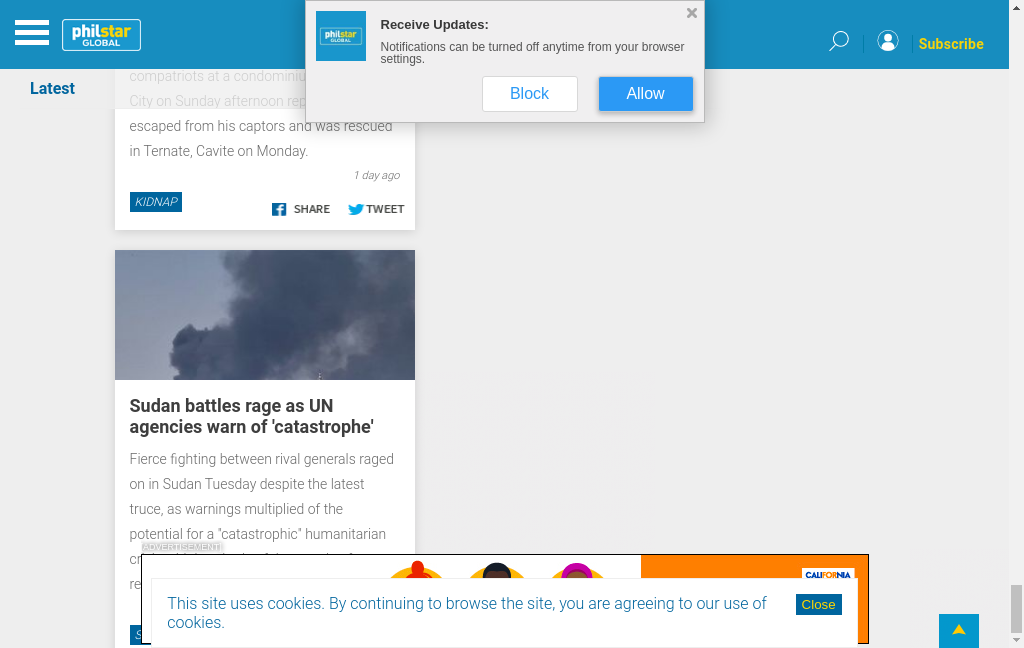

help!!!!!!!
ERROR FOR LINK: https://www.philstar.com/headlines/
<class 'selenium.common.exceptions.TimeoutException'> Line: 61
help!!!!!!!
ERROR FOR LINK: https://www.philstar.com/headlines/
<class 'selenium.common.exceptions.TimeoutException'> Line: 61
15
car Two DepEd admin officials resign; Ablan says quitting not related to laptops controversy https://www.philstar.com/headlines/2023/05/04/2263761/two-deped-admin-officials-resign-ablan-says-quitting-not-related-laptops-controversy 3 hours ago
car 42% Filipinos want ROTC only as an option in senior high — SWS poll https://www.philstar.com/headlines/2023/05/04/2263783/42-filipinos-want-rotc-only-option-senior-high-sws-poll 3 hours ago
car Bilateral Defense Guidelines include AFP modernization, cyber defense https://www.philstar.com/headlines/2023/05/04/2263749/bilateral-defense-guidelines-include-afp-modernization-cyber-defense 3 hours ago
car Evacuated Sudan OFWs to get 100k humanitarian assistance https://www.philstar.com/headlines/

,Statement,Link,Date
0,Two DepEd admin officials resign; Ablan says q...,https://www.philstar.com/headlines/2023/05/04/...,3 hours ago
1,42% Filipinos want ROTC only as an option in s...,https://www.philstar.com/headlines/2023/05/04/...,3 hours ago
2,Bilateral Defense Guidelines include AFP moder...,https://www.philstar.com/headlines/2023/05/04/...,3 hours ago
3,Evacuated Sudan OFWs to get 100k humanitarian ...,https://www.philstar.com/headlines/2023/05/04/...,3 hours ago
4,DILG identifies alternative fishing sites for ...,https://www.philstar.com/headlines/2023/05/04/...,3 hours ago
5,"UP Baguio, Cebu suspend face-to-face classes d...",https://www.philstar.com/headlines/2023/05/04/...,\nBy Janvic Mateo | 23 hours ago
6,"2 police generals, 2 colonels recommended for ...",https://www.philstar.com/headlines/2023/05/03/...,\nBy Emmanuel Tupas | 1 day ago
7,Over 150 Filipinos evacuated from Sudan to arr...,https://www.philstar.com/headlines/2023/05/02/...,\n2 days ago
8,Government printer to produce driver’s license...,https://www.philstar.com/headlines/2023/05/04/...,\nBy Bella Cariaso | 23 hours ago
9,"CHR lauds DepEd move to add red-tagging, EJK a...",https://www.philstar.com/headlines/2023/05/04/...,\nBy Cristina Chi | 12 hours ago


In [150]:
# https://www.philstar.com/headlines
# https://www.philstar.com/nation˛

site = "PhilStar"
data=pd.DataFrame(columns=['Statement','Link','Date'])
url = 'https://www.philstar.com/headlines/'
print(url)

driver = startChromeDriver()
driver.get(url)
driver.implicitly_wait(10)
counter = 2
try:
  SCROLL_PAUSE_TIME = 1
  cnt = counter
  # Get scroll height
  last_height = driver.execute_script("return document.body.scrollHeight")
  while cnt>0:
      # Scroll down to bottom
      driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
      # Wait to load page
      time.sleep(SCROLL_PAUSE_TIME)
      # Calculate new scroll height and compare with last scroll height
      new_height = driver.execute_script("return document.body.scrollHeight")
      if new_height == last_height:
          break
      last_height = new_height
      print("scrolling...")
    #   showscreen(driver)
      cnt -= 1
except Exception as e:                                   
  error_type, error_obj, error_info = sys.exc_info()      
  print ('ERROR FOR LINK:',url)                          
  print (error_type, 'Line:', error_info.tb_lineno)  

try:
  WebDriverWait(driver, timeout=30).until(EC.visibility_of_element_located((By.CLASS_NAME, 'theContent')))
  source = driver.page_source
  soup = BeautifulSoup(source, 'html.parser')
  linksCarousel  = soup.find('div', {'class':'carousel__items'}).find_all('div', {'class' : 'carousel__item__title'})
  
  WebDriverWait(driver, timeout=30).until(EC.presence_of_element_located((By.ID, 'news_main')))
  WebDriverWait(driver, timeout=60).until(EC.visibility_of_element_located((By.CLASS_NAME, 'jscroll-inner')))

  links1 = []
  links1 += soup.find('div', {'id':'news_main'}).find('div', {'class' : 'news_column trending'}).find_all('div', {'class':'tiles trend'}) 
  links1 += soup.find('div', {'id':'news_main'}).find('div', {'class' : 'news_column latest'}).find_all('div', {'class':'tiles late'}) 
  links2 = []

  if (counter >1):
    WebDriverWait(driver, timeout=60).until(EC.visibility_of_element_located((By.CLASS_NAME, 'jscroll-added')))
    linksAddJScroll = soup.find('div', {'id':'news_main'}).find_all('div', {'class':'jscroll-added'})
    showscreen(driver)
    
    for x in linksAddJScroll:
        try:
            # js_code = "arguments[0].scrollIntoView();"
            # # //*[@id="news_main"]/div/div[6]/div[2]
            # element = WebDriverWait(driver, timeout=5).until(EC.visibility_of_element_located((By.XPATH, '//*[@id="news_main"]/div/div[6]/div[2]')))
            time.sleep(2)
            WebDriverWait(driver, timeout=30).until(EC.visibility_of_element_located((By.CLASS_NAME, 'news_column trending')))
            links2 += x.find('div', {'class' : 'news_column trending'}).find_all('div', attrs={'class': re.compile('^tiles trend')})
            links2 += x.find('div', {'class' : 'news_column latest'}).find_all('div', attrs={'class': re.compile('^tiles late')})
        except:
            print('help!!!!!!!')
            error_type, error_obj, error_info = sys.exc_info()      
            print ('ERROR FOR LINK:',url)                          
            print (error_type, 'Line:', error_info.tb_lineno) 

    

#   showscreen(driver)
#   print(linksTrending,linksLatest)
except Exception as e:                                   
  error_type, error_obj, error_info = sys.exc_info()      
  print ('ERROR FOR LINK:',url)                          
  print (error_type, 'Line:', error_info.tb_lineno) 

print(len(linksCarousel)+len(links1)+len(links2))

for j in linksCarousel:
    Statement = j.find('h2').find('a').text.strip()
    Link = j.find('a')['href'].strip()
    Date = soup.find('div', {'class':'carousel__items'}).find('div', {'class' : 'carousel__item__time'}).text
    df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
    print('car',Statement, Link, Date)
    data = data.append(pd.Series(df_new_row, index=data.columns[:len(df_new_row)]), ignore_index=True)

for j in links1:
    Statement = j.find('div', {'class': 'TilesText spec'}).find('div', {'class':'news_title'}).find('h2').find('a').text.strip()
    Link = j.find('div', {'class': 'TilesText spec'}).find('div', {'class':'news_title'}).find('a')['href'].strip()
    Date = j.find('div', {'class': 'TilesText spec'}).find('div', {'class':'dateOfFeature'}).text
    df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
    print('li',Statement, Link, Date)
    data = data.append(pd.Series(df_new_row, index=data.columns[:len(df_new_row)]), ignore_index=True)

for j in links2:
    Statement = j.find('div', {'class': 'TilesText spec'}).find('div', {'class':'news_title'}).find('a').text.strip()
    Link = j.find('div', {'class': 'TilesText spec'}).find('div', {'class':'news_title'}).find('a')['href'].strip()
    Date = j.find('div', {'class': 'TilesText spec'}).find('div', {'class':'dateOfFeature'}).text
    df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
    print('li2',Statement, Link, Date)
    data = data.append(pd.Series(df_new_row, index=data.columns[:len(df_new_row)]), ignore_index=True)

display.stop_display()
driver.quit()

filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"   
data.to_csv(filename)
data

In [147]:
links2

[<div class="tiles trend article2263738">
 <div class="tiles_image">
 <div class="tiles_overflow_holder">
 <a href="https://www.philstar.com/headlines/2023/05/04/2263738/visitation-bilibid-ciw-suspended-anew-amid-covid-19-threat"><img alt="Visitation at Bilibid, CIW suspended anew amid COVID-19 threat" class="lazy" data-sizes="(max-width: 314px) 314px, (max-width: 870px) 686px, 314px" data-src="https://media.philstar.com/photos/2023/04/12/catapang-bucor_2023-04-12_13-26-19_tn.jpg" data-srcset="https://media.philstar.com/photos/2023/04/12/catapang-bucor_2023-04-12_13-26-19_thumbnail.jpg 686w, https://media.philstar.com/photos/2023/04/12/catapang-bucor_2023-04-12_13-26-19_tn.jpg 314w"/></a>
 </div>
 </div>
 <div class="TilesText spec">
 <div class="news_title"><a href="https://www.philstar.com/headlines/2023/05/04/2263738/visitation-bilibid-ciw-suspended-anew-amid-covid-19-threat">Visitation at Bilibid, CIW suspended anew amid COVID-19 threat</a></div>
 <div class="dateOfFeature">
 By <a

In [142]:
for x in linksAddJScroll:
    print(x.find('div', {'class' : 'news_column trending'}).find_all('div', attrs={'class': re.compile('^tiles trend')})_

,Statement,Link,Date
0,Two DepEd admin officials resign; Ablan says q...,https://www.philstar.com/headlines/2023/05/04/...,2 hours ago
1,42% Filipinos want ROTC only as an option in s...,https://www.philstar.com/headlines/2023/05/04/...,2 hours ago
2,Bilateral Defense Guidelines include AFP moder...,https://www.philstar.com/headlines/2023/05/04/...,2 hours ago
3,Evacuated Sudan OFWs to get 100k humanitarian ...,https://www.philstar.com/headlines/2023/05/04/...,2 hours ago
4,DILG identifies alternative fishing sites for ...,https://www.philstar.com/headlines/2023/05/04/...,2 hours ago
5,Over 150 Filipinos evacuated from Sudan to arr...,https://www.philstar.com/headlines/2023/05/02/...,\n2 days ago
6,"UP Baguio, Cebu suspend face-to-face classes d...",https://www.philstar.com/headlines/2023/05/04/...,\nBy Janvic Mateo | 23 hours ago
7,"2 police generals, 2 colonels recommended for ...",https://www.philstar.com/headlines/2023/05/03/...,\nBy Emmanuel Tupas | 1 day ago
8,Government printer to produce driver’s license...,https://www.philstar.com/headlines/2023/05/04/...,\nBy Bella Cariaso | 23 hours ago
9,"Visitation at Bilibid, CIW suspended anew amid...",https://www.philstar.com/headlines/2023/05/04/...,\nBy Kristine Joy Patag | 12 hours ago


In [ ]:
def philStarArticleScraper(url):
  print(url)
  try: 
    driver = startChromeDriver()
    driver.get(url)
    WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.CLASS_NAME, 'article__title'))) 
    source = driver.page_source
    soup=BeautifulSoup(source, 'html.parser')

    row=[]
    WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.ID, 'sports_article_writeup'))) 
    Title = soup.find('div',{'class':'article__title'}).find('h1').text.strip()
    Author = soup.find('div', attrs={'class': 'article__credits'}).find('div',attrs={'class':'article__credits-author-pub'}).text.strip()
    Date = soup.find('div', attrs={'class': 'article__credits'}).find('div', {'class': 'article__date-published'}).text[:-11].strip() 
    textList =soup.find("div", {'class' :'article__writeup'}).find_all("p")
    body = ""
    for t in textList:
        body += (t.text) +"\n" 
    row.extend((Title, Author, Date, body))
    
  except Exception as e:                                   
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)                          
      print (error_type, 'Line:', error_info.tb_lineno)
  driver.quit()
  return row

site = "PhilStar"
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site}_{date.today()}NEWS.csv"

for index, row in data.iterrows():
  url = row["Link"] 
  row = philStarArticleScraper(url)
  data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  
data2.to_csv(filename)
data2

## Rappler

In [ ]:
# https://www.rappler.com/nation/national-news/
# 

## TV5


In [ ]:
# https://news.tv5.com.ph/articles/politics
# https://news.tv5.com.ph/articles/national

## Manila Standard


In [115]:
# https://manilastandard.net/category/news/national
# https://manilastandard.net/category/news/top-stories

## Sunstar Philippines

In [ ]:
# https://www.sunstar.com.ph/morearticles/manila/local-news?pgno=1

# Application

## Scraping Function

In [55]:
def abs_scrape(url):
  abs_df = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])

  time.sleep(1)   
  soup=BeautifulSoup(extract_source(url).text, 'html.parser')
    
  row=[]
  
  Title = soup.find('h1',{'class':'news-title'}).text.strip()
  Author = soup.find('span',attrs={'class':'editor'}).text.strip()
  Date = soup.find('span', attrs={'class': 'date-posted'}).text[:-8].strip() 
  
  textList =soup.find("div", {'class' :'article-content'}).find_all("p")
  body = ""
  for t in textList:
    if (t.text != "RELATED VIDEO:"):
      body += (t.text) +"\n" 

  row.extend((Title, Author, Date, body))
  
  abs_df = abs_df.append(pd.Series(row, index=abs_df.columns[:len(row)]), ignore_index=True)
  
  return abs_df

In [54]:
def gma_scrape(url):
  gma_df = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
  
  time.sleep(2)   
  soup=BeautifulSoup(extract_source(url).text, 'html.parser')
    
  row=[]

  Title = soup.find('h1',{'class':'story_links'}).text.strip()
  Author = soup.find('div',attrs={'class':'main-byline'})
  if (Author != None):
    Author = Author.find('div').find('div').text.strip() 
  Date = soup.find('div', attrs={'class': 'article-time'}).find('time')['datetime'][:10].strip() 

  
  textList =soup.find("div", {'class' :'story_main'}).find_all("p")
  body = ""
  for t in textList:
    if (t.find('p', class_="ad")):
      pass
    else:
      body += (t.text) +"\n" 

  row.extend((Title, Author, Date, body))
  
  gma_df = gma_df.append(pd.Series(row, index=gma_df.columns[:len(row)]), ignore_index=True)

  return gma_df
  


In [61]:
def cnn_scrape(url):

  # chrome_options = webdriver.ChromeOptions()
  # chrome_options.add_argument('--headless')
  # chrome_options.add_argument('--no-sandbox')
  # chrome_options.add_argument('--disable-dev-shm-usage')
  # chrome_options.add_argument('--disable-blink-features=AutomationControlled')
  # userAgent = "Chrome/105.0.0.0"
  # chrome_options.add_argument(f"user-agent={userAgent}")
  # driver = webdriver.Chrome('chromedriver',options=chrome_options)
  driver = startChromeDriver()
  driver.get(url)
  WebDriverWait(driver, 50).until(EC.visibility_of_element_located((By.CLASS_NAME, 'title'))) 
  source = driver.page_source

  cnn_df = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
  
  soup=BeautifulSoup(source, 'html.parser')
  # time.sleep(2)   

  # print(soup)
  row=[]
  
  Title = soup.find('h1',{'class':'title'}).text.strip()
  Author = soup.find('div',attrs={'class':'author-byline'}).find('p').find('a').text.strip()
  Date = soup.find('div', attrs={'class': 'dateLine'}).find('p', {'class': 'dateString no-icon'}).text[10:-11].strip() 
  
  textList =soup.find("div", {'class' :'article-maincontent-p cnn-life-body'}).find_all("p")
  body = ""
  for t in textList:
      body += (t.text) +"\n" 

  row.extend((Title, Author, Date, body))
  

  cnn_df = cnn_df.append(pd.Series(row, index=cnn_df.columns[:len(row)]), ignore_index=True)

  return cnn_df

In [ ]:
def clean(df, text, clean_col , sw = [] ):
    """
    Remove blank texts, replaces text with lower case characters,
    remove special characters, remove other special texts like URLs and Twitter handles, 
    remove leading and trailing whitespaces, and remove stopwords.
    """

    # Remove blank texts
    df[clean_col] = df[text].fillna('')     

    # Transform into lowercase
    df[clean_col] = df[clean_col].str.lower()

    # # Remove non-alphanumeric characters
    df[clean_col] = df[clean_col].str.replace(r'(@[A-Za-z0-9_]+)|([^A-Za-z0-9_ \t])|(\w+:\/\/\S+)', '')
    
    # # Lemmatize verbs
    # df['cleaned_text'] = df['cleaned_text'].apply(lambda row: ' '.join([lemmatizer.lemmatize(x, 'v') for x in row.split()]))

    # # Lemmatize adjectives
    # df['cleaned_text'] = df['cleaned_text'].apply(lambda row: ' '.join([lemmatizer.lemmatize(x, 'a') for x in row.split()]))

    # # Lemmatize nouns
    # df['cleaned_text'] = df['cleaned_text'].apply(lambda row: ' '.join([lemmatizer.lemmatize(x, 'n') for x in row.split()]))

    # Remove trailing and leading whitespaces
    df[clean_col] = df[clean_col].str.replace(r'^\s+|\s+$', '')

    # # Remove stopwords 
    df[clean_col] = df[clean_col].apply(lambda row: ' '.join([word for word in row.split() if word not in (stopwords + sw)])) 

    return df

In [ ]:
def senti_Analysis(df, col, colLabel ):
  sia = SentimentIntensityAnalyzer()
  newcol = {'compoundScore' : [sia.polarity_scores(entry) for entry in col]}
  if (colLabel in df.columns):
      df[colLabel] =  newcol['compoundScore']
  else:
    df.insert(df.shape[1], colLabel, newcol['compoundScore'])
  

## Scrape

In [ ]:
df_ = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
df_ = df_.append(abs_scrape("https://news.abs-cbn.com/news/09/29/22/ovp-eyes-coconut-palace-as-permanent-home"), ignore_index=True)
df_ = df_.append(gma_scrape("https://www.gmanetwork.com/news/topstories/nation/846433/sara-duterte-ovp-in-talks-with-gsis-for-possible-acquisition-of-coconut-palace/story/"), ignore_index=True)
df_.head()

### Oct 6

In [62]:
df = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
abscbn = abs_scrape('https://news.abs-cbn.com/news/10/04/22/who-funded-marcos-sg-trip-not-relevant-says-bersamin')
gma = gma_scrape('https://www.gmanetwork.com/news/topstories/nation/846954/palace-marcos-performed-job-as-president-in-singapore/story/?just_in')
cnn = cnn_scrape('https://www.cnnphilippines.com/news/2022/10/4/Marcos-entitled-to-private-time-funding-source-irrelevant.html')

df = df.append(abscbn)
df = df.append(gma)
df = df.append(cnn)


In [63]:
cnn

,Title,Author,Date,Text
0,Bersamin on Singapore trip: Marcos entitled to...,CNN Philippines Staff,"Oct 4, 2022,","Metro Manila (CNN Philippines, October 4) — Ex..."


In [ ]:
addedFilter = ['executive', 'president', 'trip', 'marcos', 'bersamin']
visualize((clean(abscbn,"Text", "cleanText",addedFilter )), "cleanText", "ABS-CBN")
visualize((clean(gma,"Text", "cleanText",addedFilter)), "cleanText", "GMA")
visualize((clean(cnn,"Text", "cleanText", addedFilter)), "cleanText", "CNN")

In [ ]:
df_clean= clean(df_, 'Text', 'clean_Textbody')
df_clean= clean(df_, 'Title', 'clean_Title')
df_clean["clean_Body_Title"] = df_clean["clean_Title"].str.cat(df_clean["clean_Textbody"], sep = "\n")
df_clean.head()

In [ ]:
def POS(df, dfCol, colLabel):
  POS = []
  for index, row in df.iterrows():
    # print(type(row[dfCol]), row[dfCol])
    tokenized = sent_tokenize(row[dfCol])
    for i in tokenized:
      
      # Word tokenizers is used to find the words
      # and punctuation in a string
      wordsList = nltk.word_tokenize(i)

      wordsList = [w for w in wordsList if not w in stopwords]
  
      #  Using a Tagger. Which is part-of-speech
      # tagger or POS-tagger.
      tagged = nltk.pos_tag(wordsList)
      POS.append(tagged)
    df.loc[index, colLabel] =  POS
    
 

In [ ]:
# https://www.geeksforgeeks.org/part-speech-tagging-stop-words-using-nltk-python/
POS(df_clean, 'clean_Body_Title', "POS")
df_clean


In [ ]:
df_clean.to_csv(f"{dir}textCompare.csv")